In [1]:
!pip install gensim
!pip install contractions
import contractions
import html
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from gensim.models import FastText
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  Using cached gensim-4.2.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.0 MB)
  Using cached smart_open-6.2.0-py3-none-any.whl (58 kB)
  Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
  Using cached pyahocorasick-1.4.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (109 kB)
  Using cached anyascii-0.3.1-py3-none-any.whl (287 kB)


In [2]:
train_data = pd.read_csv('../misc/cnn_dailymail/train.csv')
val_data = pd.read_csv('../misc/cnn_dailymail/validation.csv')
test_data = pd.read_csv('../misc/cnn_dailymail/test.csv')
len(train_data)

287113

In [3]:
x = train_data['article']
y = train_data['highlights']

In [4]:
def clean(text):
    text = contractions.fix(text)
    text = html.unescape(text)
    text = str(text)
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]',' ',text) 
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = ' '.join(text.split())
    return text

In [5]:
cleaned_source = list(map(clean,x))
cleaned_summary = list(map(clean,y))

In [6]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'

for i in range(len(cleaned_summary)):
    cleaned_summary[i] = START_TOKEN + " " + cleaned_summary[i] + " " + END_TOKEN
    
print(cleaned_source[11])
print(cleaned_summary[11])

two lawyers representing a woman who claims to have had sex as a minor with prominent you s criminal defense lawyer alan dershowitz have filed a counter defamation lawsuit against him former federal judge paul cassell and florida plaintiffs attorney bradley edwards filed the lawsuit in a florida circuit court accusing dershowitz of initiating a public media assault on their reputation and character according to court documents in a filing in florida federal court last week cassell and edwards said their client identified by buckingham palace as virginia roberts was forced as a minor by financier jeffrey epstein to have sex with several people including dershowitz and prince andrew two lawyers representing virginia roberts pictured here with her husband robert giuffre in denver who claims to have had sex while a minor with prominent you s criminal defense lawyer alan dershowitz filed a counter defamation lawsuit against him on monday dershowitz who was part of o j simpson s dream team f

In [7]:
new_source = []
new_summary = []

max_source_length = 300
max_summary_length = 100

for i in range(len(cleaned_source)):
    if len(cleaned_source[i].split()) <= max_source_length and len(cleaned_summary[i].split()) <= max_summary_length :
        source = cleaned_source[i]
        reversedsource = " ".join(source.split()[::-1])
        new_source.append(reversedsource)
        new_summary.append(cleaned_summary[i])

print(len(new_source))
print(len(new_summary))

24409
24409


In [ ]:
#from gensim.models import FastText

#sentences = new_source + new_summary
#sent_ted = [] #all the words
#for sent in sentences:
#    sent_ted_child = sent.split()
#    sent_ted.append(sent_ted_child)

#model_ted = FastText(sent_ted, vector_size=128, window=3, min_count=1, workers=4,sg=1, epochs=1500)

#import pickle
#pickle.dump(model_ted, open('128_emb_cnn_400_100.pkl', 'wb'))

In [8]:
import pickle
model_ted = pickle.load(open('./128_emb_cnn_300_100.pkl', 'rb'))
weights = model_ted.wv #weight vectors representing all the words
print(model_ted.wv.most_similar("milk"))

[('dairy', 0.6152066588401794), ('breast', 0.554631233215332), ('food', 0.5541932582855225), ('lactose', 0.5267015695571899), ('mooo', 0.5247284770011902), ('alcoholic', 0.5210902690887451), ('70g', 0.5209250450134277), ('cream', 0.5195273160934448), ('gallons', 0.5182810425758362), ('aizu', 0.5173525214195251)]


In [9]:
from collections import OrderedDict 

word2Index_enc = {} #encoder word-2-index
word2Index_dec = {} #decoder word-2-index

ind2Word_enc = {} #reverse dictionaries for the above
ind2Word_dec = {}

encoder_paragraph = list(set((' '.join(new_source)).split()))

decoder_paragraph_list = list((' '.join(new_summary)).split())
decoder_dict = OrderedDict()

for word in decoder_paragraph_list: #make a freq_dict of decoder words
    try:
        decoder_dict[word] = decoder_dict[word] + 1
    except:
        decoder_dict[word] = 1

ind2Word_enc[0] = START_TOKEN
ind2Word_dec[0] = START_TOKEN
word2Index_enc[START_TOKEN] = 0
word2Index_dec[START_TOKEN] = 0
ind2Word_enc[1] = END_TOKEN
ind2Word_dec[1] = END_TOKEN
word2Index_enc[END_TOKEN] = 1
word2Index_dec[END_TOKEN] = 1
ind2Word_enc[2] = UNK_TOKEN
ind2Word_dec[2] = UNK_TOKEN
word2Index_enc[UNK_TOKEN] = 2
word2Index_dec[UNK_TOKEN] = 2


dec_index = 1
for (decoder_dict_word, decoder_dict_number) in decoder_dict.items():
    word2Index_dec[decoder_dict_word] = dec_index
    ind2Word_dec[dec_index] = decoder_dict_word
    dec_index+=1

enc_index = 1
for index,word in enumerate(encoder_paragraph):
    if word != ' ':
        word2Index_enc[word] = enc_index
        ind2Word_enc[enc_index] = word 
        enc_index+=1

In [10]:
encoder_input = [[word2Index_enc[word] for word in sentence.split() if word in word2Index_enc.keys()] for sentence in new_source ]
decoder_input = [[word2Index_dec[word] for word in sentence.split() if word in word2Index_dec.keys()] for sentence in new_summary ]

In [11]:
encoder_tensor = [torch.tensor(li ,dtype=torch.long,device=device).view(-1, 1) for li in encoder_input]
decoder_tensor = [torch.tensor(li,dtype=torch.long,device=device).view(-1, 1) for li in decoder_input]

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, hidden_size, num_layers=1, bidirectional=False):
        super(Encoder,self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_vocab_size = input_vocab_size
        self.gru_layer = nn.GRU(input_size = self.hidden_size,
                                hidden_size = self.hidden_size,
                                num_layers = self.num_layers,
                               bidirectional = self.bidirectional)
    

    def forward(self, input_, prev_hidden_state):
        #get the input word from the index
        input_word = ind2Word_enc[input_.data.tolist()[0]] 
        
        #get the weights (vector encoding of that word) from the FastText encoding
        embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1) 
        
        #input has to be (seq_length, batch_size, input_size)
        #output will be (seq_length, batch_size, D * hidden_size)
        output,prev_hidden_state = self.gru_layer(embedded_outputs, prev_hidden_state)  
        hidden = prev_hidden_state
        return output, hidden

    def init_hidden(self, batch_size):
        #hidden has to be ((D * num_layers), batch_size, hidden_size)
        return torch.zeros(self.num_directions * self.num_layers,batch_size,self.hidden_size,device=device)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, hidden_size, dropout_value, num_layers=1):
        super(Decoder,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_vocab_size = output_vocab_size
        self.dropout_p = dropout_value
        self.embedding_layer = nn.Embedding(self.output_vocab_size, self.hidden_size)

        self.gru_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers = num_layers)
        self.output_layer = nn.Linear(self.hidden_size, self.output_vocab_size)
        self.dropout_layer = nn.Dropout(self.dropout_p)

    def forward(self, input_, prev_hidden_state):
        input_word = ind2Word_dec[input_.data.tolist()[0]]
        embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1)
        embeddings_dropout = self.dropout_layer(embedded_outputs)
        hidden = prev_hidden_state[-1, :, :].unsqueeze(0) #only using the last hidden state
        output,hidden = self.gru_layer(embeddings_dropout, hidden)
        output_logits = self.output_layer(output)
        output_softmax = nn.functional.log_softmax(output_logits[0], dim=1)
        return output_softmax, hidden

In [ ]:
teacher_forcing_ratio = 0.5
batch_size = 1

def train(encoder, 
          decoder, 
          input_tensor, 
          target_tensor, 
          encoder_optimizer, 
          decoder_optimizer, 
          criterion, 
          max_length, 
          iters, encoder_scheduler, decoder_scheduler):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_hidden = encoder.init_hidden(batch_size) 

    input_length = input_tensor.size(0) #number of words in the input
    output_length = target_tensor.size(0) #in the output

    loss = 0

    for encoder_index in range(0, input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[encoder_index], encoder_hidden)

    #start the decoder with the start of sentence token
    decoder_input = torch.tensor([word2Index_dec[START_TOKEN]],device=device)   
    #pass it the encoder hidden as context vector
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for decoder_index in range(output_length):
            decoder_output, decoder_hidden = \
            decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[decoder_index])
            decoder_input = target_tensor[decoder_index]
    else:
        for decoder_index in range(output_length):
            decoder_output, decoder_hidden = \
            decoder(decoder_input, decoder_hidden) 
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach() 
            
            loss += criterion(decoder_output, target_tensor[decoder_index])
            
            try:
                if decoder_input.item() == word2Index_dec[END_TOKEN]:
                    break
            except KeyError:
                continue
            
    loss.backward()
    
    #clip the gradient
    if iters % 20000 == 0:
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.4)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.4)

    encoder_optimizer.step()
    decoder_optimizer.step()
    encoder_scheduler.step()
    decoder_scheduler.step()

    return loss.item()/output_length

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    if percent != 0:
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    else:
        return 0

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [57]:
# Dictionary for creating loss graph
loss_graph = {}
lr_graph = {}

def train_Iters(encoder, decoder, n_iters, print_every=50, plot_every=100,learning_rate = 0.03):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    encoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(encoder_optimizer,
                              T_max = 30000, # Maximum number of iterations.
                             eta_min = 0.001) # Minimum learning rate.
    decoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(decoder_optimizer,
                              T_max = 30000, # Maximum number of iterations.
                             eta_min = 0.001) # Minimum learning rate.
    
    
    
    training_pairs = [random.choice(pairs) for i in range(n_iters)]
  
    criterion = nn.NLLLoss()
    for iters in range(n_iters):
        training_pair = training_pairs[iters - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        input_tensor = torch.tensor(input_tensor, dtype=torch.long, device = device).view(-1, 1)
        target_tensor = torch.tensor(target_tensor, dtype=torch.long, device = device).view(-1, 1)

        loss = train(encoder, decoder, input_tensor, target_tensor,
                     encoder_optimizer, decoder_optimizer, criterion,
                     max_source_length, iters, encoder_scheduler, decoder_scheduler)
        print_loss_total += loss
        plot_loss_total += loss

        if iters % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            progress = iters / n_iters
            print('%s (%s %d%%) %.4f' % (timeSince(start, progress), iters, progress * 100, print_loss_avg))

            if iters > 0:
                loss_graph[iters] = print_loss_avg
                lr_graph[iters] = encoder_scheduler.get_last_lr()

        if iters % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
  

In [18]:
pairs = []
for enc,dec in zip(encoder_input,decoder_input):
    pairs.append([enc,dec])

In [58]:
hidden_size = 128
rnn_encoder = Encoder(len(word2Index_enc.keys()), hidden_size, num_layers = 4, bidirectional = True).to(device = device)
rnn_decoder = Decoder(len(word2Index_dec.keys()), hidden_size, 0.2).to(device = device)

In [20]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [21]:
encoder_path = './cnn_enc_rnn.w'
decoder_path = './cnn_decoder_rnn.w'

#torch.save(rnn_encoder.state_dict(), encoder_path)
#torch.save(rnn_decoder.state_dict(), decoder_path)

#loading since training was done before

rnn_encoder.load_state_dict(torch.load(encoder_path))
#rnn_encoder.eval()
rnn_decoder.load_state_dict(torch.load(decoder_path))
#rnn_decoder.eval()

<All keys matched successfully>

In [26]:
%matplotlib inline

0 (0 0%) 0.2129
0m 21s (- 217m 7s) (50 0%) 7.4552
0m 44s (- 220m 50s) (100 0%) 9.0322
1m 5s (- 217m 15s) (150 0%) 7.8665
1m 25s (- 212m 17s) (200 0%) 7.2959
1m 45s (- 208m 27s) (250 0%) 6.7419
2m 8s (- 211m 18s) (300 1%) 6.9613
2m 29s (- 211m 27s) (350 1%) 7.0377
2m 51s (- 211m 48s) (400 1%) 6.9003
3m 11s (- 209m 13s) (450 1%) 6.6822
3m 33s (- 209m 50s) (500 1%) 6.5697
3m 55s (- 210m 18s) (550 1%) 6.7535
4m 17s (- 210m 26s) (600 2%) 6.7450
4m 38s (- 209m 50s) (650 2%) 6.5028
4m 59s (- 208m 53s) (700 2%) 6.6448
5m 21s (- 208m 45s) (750 2%) 6.9706
5m 41s (- 207m 34s) (800 2%) 6.9870
6m 2s (- 206m 59s) (850 2%) 6.9423
6m 23s (- 206m 43s) (900 3%) 6.8586
6m 43s (- 205m 49s) (950 3%) 6.4023
7m 4s (- 204m 59s) (1000 3%) 6.8604
7m 25s (- 204m 52s) (1050 3%) 6.3580
7m 48s (- 205m 6s) (1100 3%) 6.4326
8m 9s (- 204m 42s) (1150 3%) 6.7254
8m 30s (- 204m 5s) (1200 4%) 7.0169
8m 52s (- 203m 58s) (1250 4%) 6.3259
9m 13s (- 203m 42s) (1300 4%) 6.9981
9m 34s (- 203m 7s) (1350 4%) 6.6639
9m 55s (- 202m

<Figure size 432x288 with 0 Axes>

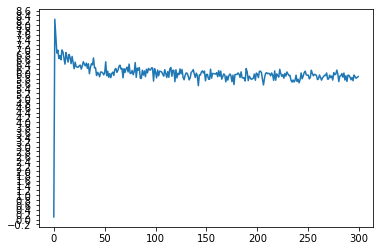

In [59]:
train_Iters(rnn_encoder, rnn_decoder, 30000)

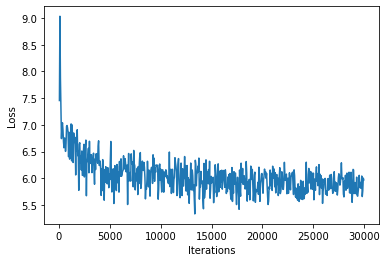

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

iters = list(loss_graph.keys())
loss_val = list(loss_graph.values())
plt.plot(iters, loss_val)
plt.xlabel('Iterations') 
plt.ylabel('Loss')  
plt.show()

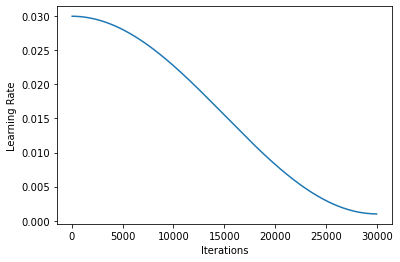

In [61]:
lr_iters = list(lr_graph.keys())
lr_val = list(lr_graph.values())
plt.plot(lr_iters, lr_val)
plt.xlabel('Iterations') 
plt.ylabel('Learning Rate')  
plt.show()

In [62]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        pair1 = torch.tensor(pair[0],dtype=torch.long,device=device)
        pair2 = pair[1]
        output_words = evaluate(encoder, decoder, pair1)
        output_sentence = ' '.join(output_words)
        output_list = [ind2Word_dec[word] for word in pair2]
        output_list = ' '.join(output_list)
        input_sentence = [ind2Word_enc[element.item()] for element in pair1.flatten()]
        input_sentence = ' '.join(input_sentence)
        print("Article: ",input_sentence)
        print('\n<', output_sentence)
        print('\n Summary =', output_list)
        print('\n')

In [65]:
def evaluate(encoder, decoder, encoder_tensor, max_length= 10):
    with torch.no_grad():
        input_tensor = encoder_tensor
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden(batch_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0),
                                                     encoder_hidden)

        decoder_input = torch.tensor([word2Index_dec[START_TOKEN]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if ind2Word_dec[topi.item()] == END_TOKEN:
                decoded_words.append(END_TOKEN)
                break
            else:
                decoded_words.append(ind2Word_dec[topi.item()])

            decoder_input = topi.squeeze(1).detach()

        return decoded_words

In [64]:
evaluateRandomly(rnn_encoder, rnn_decoder)

Article:  undone be cannot damage the hands wrong the into released been have box s pandora of contents the once because confidentiality patient compromise not will strategy information the that government the from commitment firm a want we trust of relationship the in breakdown a cause could it happen not does this if and confidential kept be to doctor their to give they information the expect patients fallout the with deal to doctor the on pressure extra put and relationships their for consequences dire have could this home at open record online their leave accidentally to were they if partner their of hands the at abuse about doctor their informs who patient the or knowing mother her without termination a had has who girl teenage the imagine hands wrong the into gets information medical confidential when doctors and patients for wrong go can things how hand first seen has mps said mps at communications and policy of director bown stephanie dr services improve and pounds of billions 

In [66]:
evaluateRandomly(rnn_encoder, rnn_decoder)

Article:  police the to over money handing question in teachers three the saw she investigation the during point one at that claims also girl the allegations up cover police a of part as confess to forced was pensioner the that believe family s girl the daughter newborn and mother her with sits old year 12 the jail in years 12 to sentenced been has man old year 74 the quiet keep to school her of headteacher the by threatened also was she claims she police the to over money handing question in teachers three the saw she investigation the during point one at that claims also girl the daughter her fathered they if see to teachers three the of any from taken not was dna that believe they up cover police a of part as confess to forced was pensioner the that believe family her teachers her of three by repeatedly by raped was she that claims she instead father s baby the was he revealed reportedly evidence dna after crime the for police by arrested been has china province hunan qiyang in vill

In [ ]:
x_test = test_data['article']
y_test = test_data['highlights']

cleaned_source_test = list(map(clean,x_test))
cleaned_summary_test = list(map(clean,y_test))

for i in range(len(cleaned_summary_test)):
    cleaned_summary_test[i] = START_TOKEN + " " + cleaned_summary_test[i] + " " + END_TOKEN

max_source_length = 300
max_summary_length = 100
    
new_source_test = []
new_summary_test = []

for i in range(len(cleaned_source_test)):
    if len(cleaned_source_test[i].split()) <= max_source_length and len(cleaned_summary_test[i].split()) <= max_summary_length :
        new_source_test.append(cleaned_source_test[i])
        new_summary_test.append(cleaned_summary_test[i])
    
encoder_input_test = [[word2Index_enc[word] for word in sentence.split() if word in word2Index_enc.keys()] for sentence in new_source_test ]
decoder_input_test = [[word2Index_dec[word] for word in sentence.split() if word in word2Index_dec.keys()] for sentence in new_summary_test ]
    

pairs_test = []
for enc,dec in zip(encoder_input_test,decoder_input_test):
    pairs_test.append([enc,dec])

In [ ]:
from tqdm import tqdm

In [ ]:
def evaluateForRouge(encoder, decoder, n=10):
    preds = []
    references = []
    for i in tqdm(range(len(pairs_test))):
        pair = pairs_test[i]
        pair1 = torch.tensor(pair[0],dtype=torch.long,device=device)
        pair2 = pair[1]
        output_words = evaluate(encoder, decoder, pair1)
        output_sentence = ' '.join(output_words)
        output_list = [ind2Word_dec[word] for word in pair2]
        output_list = ' '.join(output_list)
        preds.append(output_sentence)
        references.append(output_list)
    return preds, references

In [ ]:
preds, references = evaluateForRouge(rnn_encoder, rnn_decoder)

In [ ]:
import evaluate as hf_evaluate

rouge_score = hf_evaluate.load("rouge")

In [ ]:
scores = rouge_score.compute(
    predictions=preds, references=references
)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(scores[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

In [ ]:
from nltk.tokenize import sent_tokenize
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["article"]]
    return metric.compute(predictions=summaries, references=dataset["highlights"])

In [ ]:
baseline_score = evaluate_baseline(test_data, rouge_score)
rouge_dict_bl = dict((rn, round(baseline_score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict_bl